In [28]:
import pickle as pkl
from opt.mc_sim import *
import time
from common.variables import *
from opt.eval_policy import *

filename = "output/msource_value_dic_11-09-2022-12-39-06.pkl"

with open(filename, 'rb') as f:
    output_obj = pkl.load(f)

value_dic = output_obj["state_value_dic"]
model_params = output_obj["model_params"]
sourcingEnv = output_obj["mdp_env"]

# sourcingEnv2 = SourcingEnv(
#     lambda_arrival = model_params['mdp_env_params']['lambda'], # or 10
#     procurement_cost_vec = np.array(model_params['mdp_env_params']['procurement_cost_vec']),
#     supplier_lead_times_vec = np.array(model_params['mdp_env_params']['supplier_lead_times_vec']),
#     on_times = np.array(model_params['mdp_env_params']['on_times']), 
#     off_times = np.array(model_params['mdp_env_params']['off_times']),
#     fixed_costs = np.array(model_params['mdp_env_params']['fixed_costs'])) # np.array([np.Inf, np.Inf])) 

sourcingEnv2 = sourcingEnv

s_custom = MState(stock_level = 0, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

In [29]:
mc_avg_costs_ss = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 100,
    nested_mc_iters = 100,
    policy_callback = ss_policy_fastest_supp_backlog,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    use_tqdm = True)

print(np.mean(np.array(mc_avg_costs_ss)))
print(np.median(np.array(mc_avg_costs_ss)))
print(np.std(np.array(mc_avg_costs_ss)))

100%|██████████| 100/100 [00:04<00:00, 21.14it/s]

25.220693069306932
21.71782178217822
10.59509796843286


In [30]:
# import matplotlib.pyplot as plt

# costs, avg_cost_per_period = mc_episode_with_policy(sourcingEnv2, policy = ss_policy_fastest_supp_backlog, periods = 1000,
#     nested_mc_iters = 100,
#     policy_callback = ss_policy_fastest_supp_backlog,
#     big_s = model_params['policy_params']['big_s'],
#     small_s = model_params['policy_params']['small_s'],
#     h_cost = model_params['policy_params']['h_cost'],
#     b_penalty = model_params['policy_params']['b_penalty'],
#     use_tqdm = True)

# # costs
# plt.plot(costs)

In [31]:
single_supplier_mean_costs = []
for s in range(sourcingEnv2.n_suppliers):

    kwargs = {"periods" : 100,
        "nested_mc_iters" : 100,
        "h_cost": model_params['policy_params']['h_cost'],
        "b_penalty" : model_params['policy_params']['b_penalty'],
        "supplier_index": s
    }

    single_supplier_costs = mc_with_policy(sourcingEnv2, start_state = s_custom, 
        use_tqdm = True,
        policy_callback = single_source_orderupto_policy,
        **kwargs)
    
    single_supplier_mean_costs.append(np.mean(single_supplier_costs))

print(single_supplier_mean_costs)
print(np.min(single_supplier_mean_costs))

100%|██████████| 100/100 [00:06<00:00, 15.99it/s]

[34.98653465346534, 21.579108910891087]
21.579108910891087


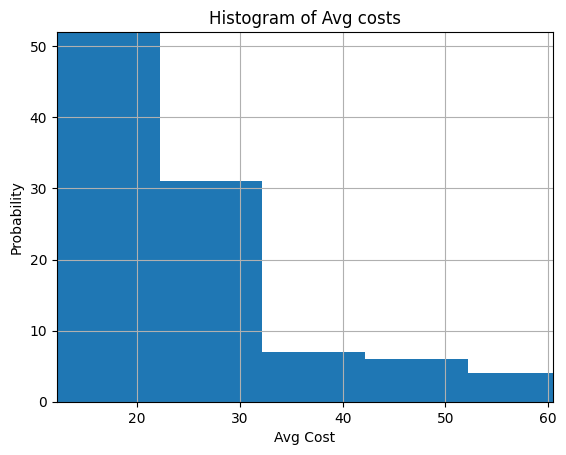

In [32]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(mc_avg_costs_ss, bins=np.arange( np.min(mc_avg_costs_ss), np.max(mc_avg_costs_ss) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs_ss), np.max(mc_avg_costs_ss))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [33]:
mc_avg_costs_di = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 20,
    nested_mc_iters = 20,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    policy_callback=dual_index_policy,
    use_tqdm = True)

print(np.mean(np.array(mc_avg_costs_di)))
print(np.median(np.array(mc_avg_costs_di)))
print(np.std(np.array(mc_avg_costs_di)))

  0%|          | 0/20 [00:00<?, ?it/s]/home/larkin/code/multi-sourcing-inventory/sim/policies.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  overshoot_range = np.array([x for x in sourcingEnv.action_history_tuple if tmark_reg < x[0] < tmark_exp])
100%|██████████| 20/20 [00:43<00:00,  2.17s/it]

19.15476190476191
19.38095238095238
10.829296736189912


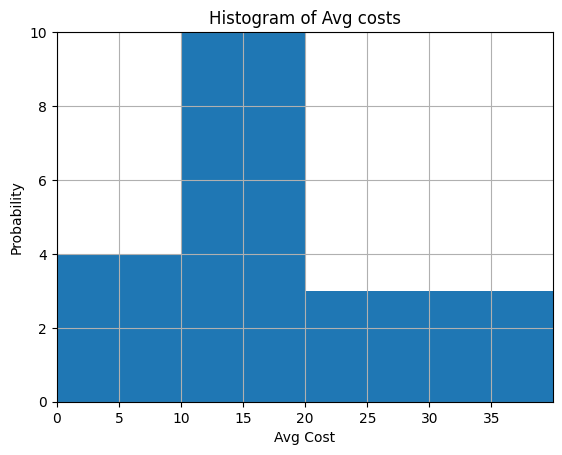

In [34]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(mc_avg_costs_di, bins=np.arange( np.min(mc_avg_costs_di), np.max(mc_avg_costs_di) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs_di), np.max(mc_avg_costs_di))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [35]:
from sim.dual_index_v1 import *
mc_avg_costs_di = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 30,
    nested_mc_iters = 30,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    policy_callback=dual_index_policy_v1,
    use_tqdm = True)

print(np.mean(np.array(mc_avg_costs_di)))
print(np.median(np.array(mc_avg_costs_di)))
print(np.std(np.array(mc_avg_costs_di)))

  0%|          | 0/30 [00:00<?, ?it/s]/home/larkin/code/multi-sourcing-inventory/sim/dual_index_v1.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  overshoot_range = np.array([x for x in sourcingEnv.action_history_tuple if tmark_reg < x[0] < tmark_exp])
100%|██████████| 30/30 [04:29<00:00,  8.97s/it]

15.496774193548386
13.467741935483872
8.958413961998712


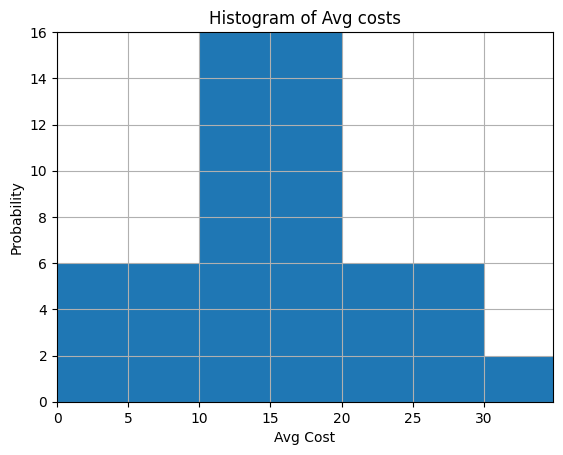

In [36]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(mc_avg_costs_di, bins=np.arange( np.min(mc_avg_costs_di), np.max(mc_avg_costs_di) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs_di), np.max(mc_avg_costs_di))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [37]:
myopic_cost = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 20,
    nested_mc_iters = 20,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    policy_callback=myopic2_policy,
    use_tqdm = True)

print(np.mean(myopic_cost))
print(np.median(np.array(myopic_cost)))
print(np.std(np.array(myopic_cost)))

100%|██████████| 20/20 [02:19<00:00,  6.95s/it]

103.52619047619048
115.02380952380952
45.77431196702384


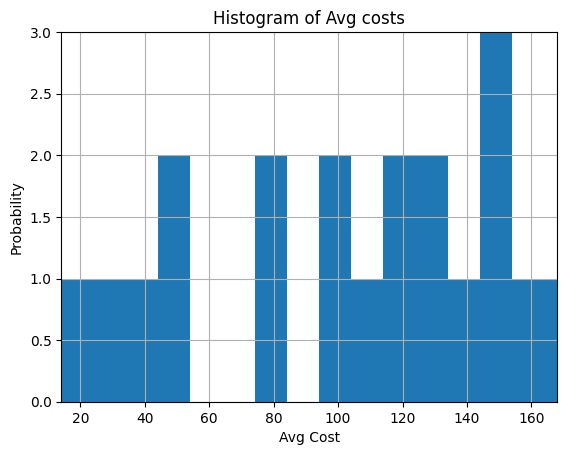

In [38]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(myopic_cost, bins=np.arange( np.min(myopic_cost), np.max(myopic_cost) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)

plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(myopic_cost), np.max(myopic_cost))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [39]:
kwargs = {
    "value_dic": value_dic, 
    "periods": 10, 
    "periods_val_it": 1,
    "nested_mc_iters": 30,
    "max_stock": BIG_S,
    "discount_fac": DISCOUNT_FAC,
    "h_cost": model_params['policy_params']['h_cost'],
    "b_penalty": model_params['policy_params']['b_penalty'],
    "n_visit_lim": N_VISIT_LIM,
    "default_ss_policy": ss_policy_fastest_supp_backlog,
    "safe_factor": SAFE_FACTOR,
    "sub_eval_periods": SUB_EVAL_PERIODS,
    "sub_nested_mc_iter": SUB_NESTED_MC_ITER,
    "max_stock": 2,
    "approx_eval": True
}

mc_avg_costs = mc_with_policy(sourcingEnv2, 
    start_state = s_custom, 
    use_tqdm = True,
    policy_callback = eval_policy_from_value_dic,
    **kwargs)

print(np.mean(mc_avg_costs))
print(np.median(mc_avg_costs))
print(np.std(mc_avg_costs))

100%|██████████| 30/30 [07:57<00:00, 15.91s/it]

37.3090909090909
31.18181818181818
12.588980270157876


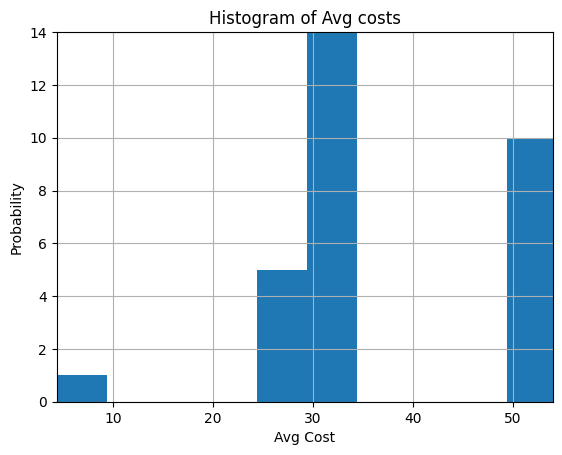

In [40]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 5
n, bins, patches = plt.hist(mc_avg_costs, bins=np.arange( np.min(mc_avg_costs), np.max(mc_avg_costs) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs), np.max(mc_avg_costs))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()